In [1]:
import tensorflow as tf
import numpy as np

In [3]:
input_dir_path = "D:/College/Fall2023/electron_cme_data"
input_file_path = "D:/College/Fall2023/electron_cme_data/sep_event_1.csv"

In [4]:
import pandas as pd

data = pd.read_csv(input_file_path)

# Display the first few rows of the dataset for inspection
data.head()


,Event ID,Timestamp,Target Timestamp,Proton Intensity,tminus24,tminus23,tminus22,tminus21,tminus20,tminus19,...,CPA,Halo,Type2_Viz_Area,solar_wind_speed,diffusive_shock,half_richardson_value,CMEs Past Month,CMEs Past 9 Hours,CMEs Speed > 1000,Max CME Speed
0,1,2010-08-14 07:55:00,2010-08-14 08:25:00,0.000189,1.423340,1.690216,1.571612,1.334376,1.512280,1.423344,...,0,0,0,0.0,0.0,0.0,4,0,0,0
1,1,2010-08-14 08:00:00,2010-08-14 08:30:00,0.000340,1.690216,1.571612,1.334376,1.512280,1.423344,1.986720,...,0,0,0,0.0,0.0,0.0,4,0,0,0
2,1,2010-08-14 08:05:00,2010-08-14 08:35:00,0.000340,1.571612,1.334376,1.512280,1.423344,1.986720,1.393684,...,0,0,0,0.0,0.0,0.0,4,0,0,0
3,1,2010-08-14 08:10:00,2010-08-14 08:40:00,0.000264,1.334376,1.512280,1.423344,1.986720,1.393684,1.690200,...,0,0,0,0.0,0.0,0.0,4,0,0,0
4,1,2010-08-14 08:15:00,2010-08-14 08:45:00,0.000340,1.512280,1.423344,1.986720,1.393684,1.690200,1.986740,...,0,0,0,0.0,0.0,0.0,4,0,0,0


In [5]:
# Extracting the relevant columns
input_columns = [f'tminus{i}' for i in range(24, 0, -1)] + ['t'] # Columns from tminus24 to tminus1
target_column = 'Proton Intensity'

# Selecting the relevant data
inputs = data[input_columns]
target = data[target_column]

# Applying logarithmic transformation with a small constant to avoid log(0)
inputs_log = np.log(inputs + 1e-6)
target_log = np.log(target + 1e-6)

# Display the transformed data
inputs_log.head(), target_log.head()


(   tminus24  tminus23  tminus22  tminus21  tminus20  tminus19  tminus18  \
 0  0.353007  0.524857  0.452102  0.288465  0.413619  0.353010  0.686486   
 1  0.524857  0.452102  0.288465  0.413619  0.353010  0.686486  0.331951   
 2  0.452102  0.288465  0.413619  0.353010  0.686486  0.331951  0.524847   
 3  0.288465  0.413619  0.353010  0.686486  0.331951  0.524847  0.686496   
 4  0.413619  0.353010  0.686486  0.331951  0.524847  0.686496  0.701314   
 
    tminus17  tminus16  tminus15  ...   tminus9   tminus8   tminus7   tminus6  \
 0  0.331951  0.524847  0.686496  ...  0.433029  0.393811  0.413628  0.008140   
 1  0.524847  0.686496  0.701314  ...  0.393811  0.413628  0.008140  0.352993   
 2  0.686496  0.701314  0.507158  ...  0.413628  0.008140  0.352993  0.353010   
 3  0.701314  0.507158  0.576151  ...  0.008140  0.352993  0.353010  0.331960   
 4  0.507158  0.576151  0.413616  ...  0.352993  0.353010  0.331960  0.470789   
 
     tminus5   tminus4   tminus3   tminus2   tminus1  

In [30]:
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, LeakyReLU
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import random

# Seeds for reproducibility
seed_value = 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

In [31]:
# Reshape the input data
X = inputs_log.values.reshape((inputs_log.shape[0], 25, 1))
print(f'X: {X}')
print(f'X.shape: {X.shape}')

X: [[[0.35300692]
  [0.52485692]
  [0.45210248]
  ...
  [0.47078895]
  [0.43304201]
  [0.60893534]]

 [[0.52485692]
  [0.45210248]
  [0.28846452]
  ...
  [0.43304201]
  [0.60893534]
  [0.62493311]]

 [[0.45210248]
  [0.28846452]
  [0.41361911]
  ...
  [0.60893534]
  [0.62493311]
  [0.39381147]]

 ...

 [[6.05009188]
  [6.02057665]
  [5.98838481]
  ...
  [5.49222159]
  [5.53103891]
  [5.51492763]]

 [[6.02057665]
  [5.98838481]
  [5.94024494]
  ...
  [5.53103891]
  [5.51492763]
  [5.47596971]]

 [[5.98838481]
  [5.94024494]
  [5.88704803]
  ...
  [5.51492763]
  [5.47596971]
  [5.51873722]]]
X.shape: (80, 25, 1)


In [32]:
y = target_log.values
print(f'y: {y}')
print(f'y.shape: {y.shape}')

y: [-8.57023538e+00 -7.98480179e+00 -7.98480179e+00 -8.23527520e+00
 -7.98480179e+00 -9.47863821e+00 -8.38879998e+00 -9.07754175e+00
 -8.79206434e+00 -7.87973315e+00 -7.98480179e+00 -9.07754175e+00
 -8.79206434e+00 -8.79207751e+00 -8.38879998e+00 -1.01587928e+01
 -8.79206434e+00 -7.78466185e+00 -8.10222009e+00 -9.47863821e+00
 -8.79207751e+00 -9.07755926e+00 -8.57023538e+00 -9.47866436e+00
 -8.79205118e+00 -8.57023538e+00 -8.38879998e+00 -7.98480179e+00
 -8.10222670e+00 -7.78466185e+00 -6.78287394e+00 -6.71840846e+00
 -5.74200784e+00 -5.27211175e+00 -4.08459227e+00 -3.29229634e+00
 -2.55936299e+00 -1.81811782e+00 -1.26530697e+00 -1.20579112e+00
 -9.64276345e-01 -8.76409179e-01 -7.68342821e-01 -8.71338877e-01
 -1.05920025e+00 -7.44859510e-01 -1.97591552e-01 -2.27723325e-02
  6.81267632e-02  1.55139619e-01  1.95699176e-01  2.87267737e-01
  2.76601661e-01  3.15584893e-01  2.72361053e-01  1.43806794e-01
  6.41375032e-02 -9.07707984e-02 -1.76485420e-01 -1.84436191e-01
 -5.55713163e-01 -4.43

In [33]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
def create_cnn(input_dim: int = 25, 
                     output_dim: int = 1, 
                     filters: int = 9, 
                     kernel_size: int = 10, 
                     dense_units: int = 50) -> Model:
    """
    Create a CNN model with 1D convolutional layers and a fully connected layer.

    Parameters:
    input_dim (int): The number of timesteps in the input data. Default is 25.
    output_dim (int): The dimension of the output layer. Default is 1 for regression tasks.
    filters (int): The number of filters in each convolutional layer. Default is 9.
    kernel_size (int): The size of the kernel in the convolutional layers. Default is 10.
    dense_units (int): The number of units in the fully connected layer. Default is 50.

    Returns:
    Model: A Keras model instance.
    """

    # Define the input layer
    input_layer = Input(shape=(input_dim, 1))

    # Add convolutional layers with LeakyReLU activation
    conv1 = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(input_layer)
    conv1 = LeakyReLU()(conv1)
    conv2 = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(conv1)
    conv2 = LeakyReLU()(conv2)

    # Flatten the output for the fully connected layer
    flattened = Flatten()(conv2)

    # Add a fully connected layer with LeakyReLU activation
    dense = Dense(dense_units)(flattened)
    dense = LeakyReLU()(dense)

    # Output layer
    output_layer = Dense(output_dim)(dense)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

In [ ]:
def create_cnn_var(output_dim: int = 1, 
                     filters: int = 9, 
                     kernel_size: int = 10, 
                     dense_units: int = 50) -> Model:
    """
    Create a CNN model with 1D convolutional layers and a fully connected layer that can handle variable-length input.

    Parameters:
    output_dim (int): The dimension of the output layer. Default is 1 for regression tasks.
    filters (int): The number of filters in each convolutional layer. Default is 9.
    kernel_size (int): The size of the kernel in the convolutional layers. Default is 10.
    dense_units (int): The number of units in the fully connected layer. Default is 50.

    Returns:
    Model: A Keras model instance.
    """

    # Define the input layer with None to allow variable-length sequences
    input_layer = Input(shape=(None, 1))

    # Add convolutional layers with LeakyReLU activation
    conv1 = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(input_layer)
    conv1 = LeakyReLU()(conv1)
    conv2 = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(conv1)
    conv2 = LeakyReLU()(conv2)

    # Use Global Average Pooling to handle variable-length sequences
    pooled = GlobalAveragePooling1D()(conv2)

    # Add a fully connected layer with LeakyReLU activation
    dense = Dense(dense_units)(pooled)
    dense = LeakyReLU()(dense)

    # Output layer
    output_layer = Dense(output_dim)(dense)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

In [35]:
model = create_cnn_model()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 25, 1)]           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 25, 9)             99        
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 25, 9)             0         
                                                                 
 conv1d_5 (Conv1D)           (None, 25, 9)             819       
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 25, 9)             0         
                                                                 
 flatten_2 (Flatten)         (None, 225)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                1130

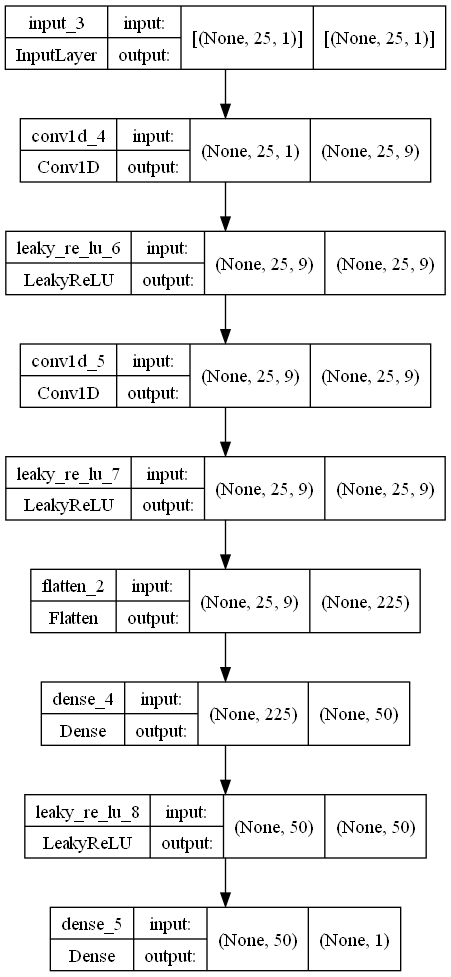

In [36]:
# Plot the model
plot_model(model, show_shapes=True, show_layer_names=True)

In [37]:
def plot_conv1d_filters(model: Model, layer_index: int, num_columns: int = 3):
    """
    Plots the filters of a 1D convolutional layer in a grid.

    Parameters:
    model (Model): The trained Keras model.
    layer_index (int): The index of the convolutional layer to visualize.
    num_columns (int): Number of columns in the grid for displaying filters. Default is 3.
    """
    # Extracting the filters and biases from the specified layer
    filters, biases = model.layers[layer_index].get_weights()

    # Number of filters
    num_filters = filters.shape[2]

    # Number of rows to display
    num_rows = num_filters // num_columns + (num_filters % num_columns > 0)

    # Setting up the plot
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 5, num_rows * 4))
    axes = axes.flatten()

    # Plotting each filter
    for i in range(num_filters):
        # Get the filter
        f = filters[:, :, i].flatten()  # Flatten to 1D array if necessary

        # Plotting
        ax = axes[i]
        ax.plot(f, label=f'Weights in Filter {i}')
        ax.set_title(f'Filter {i}')
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Weight Value')
        
        # Show the legend for the first filter only, for clarity
        if i == 0:
            ax.legend()

    # Hide unused axes
    for ax in axes[num_filters:]:
        ax.axis('off')

    plt.tight_layout()
    plt.suptitle(f'Convolutional Layer {layer_index} Filters Visualization', fontsize=16, y=1.02)
    plt.show()

In [61]:
from typing import Tuple


def create_synthetic_dataset(n_samples: int = 1000000, n_timesteps: int = 25) -> Tuple[np.ndarray]:
    """
    Creates a synthetic dataset consisting of sequences that represent a flat line followed
    by a 45-degree angled line. Each sequence is a pair of these lines.

    Parameters:
    n_samples (int): The number of samples to generate in the dataset.
    n_timesteps (int): The total number of timesteps in each sample.
    
    Returns:
    np.ndarray: A numpy array of shape (n_samples, n_timesteps, 1) containing the synthetic dataset.
    """
    
    # if odd add plus one
    offset = n_timesteps % 2 
    
    # Create a flat line for half the timesteps
    flat_line = np.zeros((n_samples, int(n_timesteps / 2 + offset), 1))
    
    # Create a 45-degree line for the other half
    angle = 45
    radians = np.deg2rad(angle)
    tan = np.tan(radians)
    line_45_deg = tan * np.arange(0, int(n_timesteps / 2)).reshape(-1, 1)
    line_45_deg = line_45_deg.reshape(1, -1, 1)
    line_45_deg = np.repeat(line_45_deg, n_samples, axis=0)
    
    # Concatenate the flat line and the 45-degree line
    synthetic_data = np.concatenate((flat_line, line_45_deg), axis=1)
    
    # Generate dummy targets (we won't actually use these for training in this example)
    targets = np.zeros((n_samples, 1))
    
    return synthetic_data, targets

In [62]:
X,y = create_synthetic_dataset()
print(X.shape)
print(y.shape)



(1000000, 25, 1)
(1000000, 1)


In [63]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
def plot_synthetic_sample(synthetic_data: np.ndarray, sample_index: int = None) -> None:
    """
    Plots a random sample from the synthetic dataset. If a sample index is provided, 
    plots that specific sample.

    Parameters:
    synthetic_data (np.ndarray): The synthetic dataset with shape (n_samples, n_timesteps, 1).
    sample_index (int, optional): The index of the specific sample to plot. If None, a random
                                  sample will be plotted. Defaults to None.
    """
    
    if sample_index is None:
        sample_index = np.random.randint(low=0, high=synthetic_data.shape[0])
    
    # Extract the specific sample
    sample = synthetic_data[sample_index, :, 0]  # Remove the last dimension as it's 1
    
    # Plot the sample
    plt.figure(figsize=(10, 4))
    plt.plot(sample, marker='o')
    plt.title(f'Synthetic Data Sample at Index {sample_index}')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

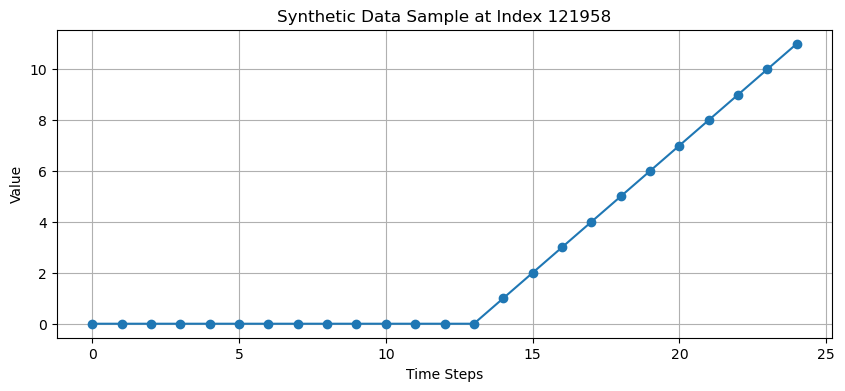

In [68]:
plot_synthetic_sample(X)

### before training

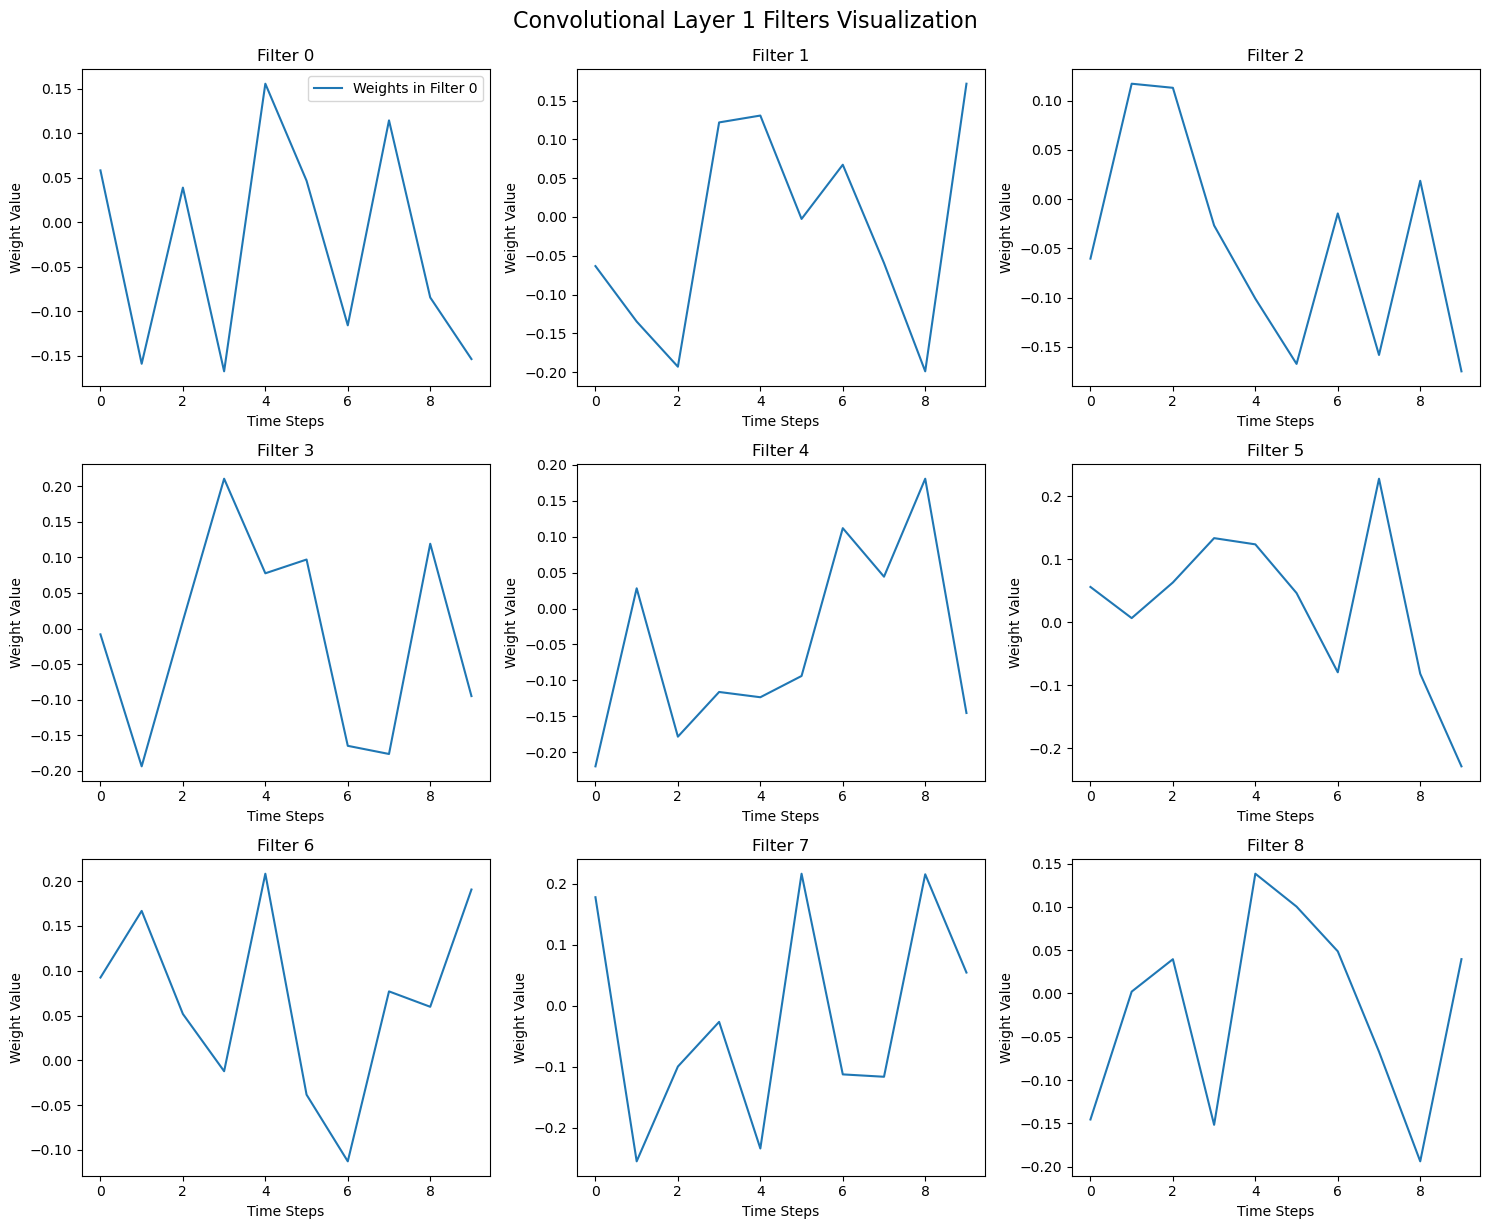

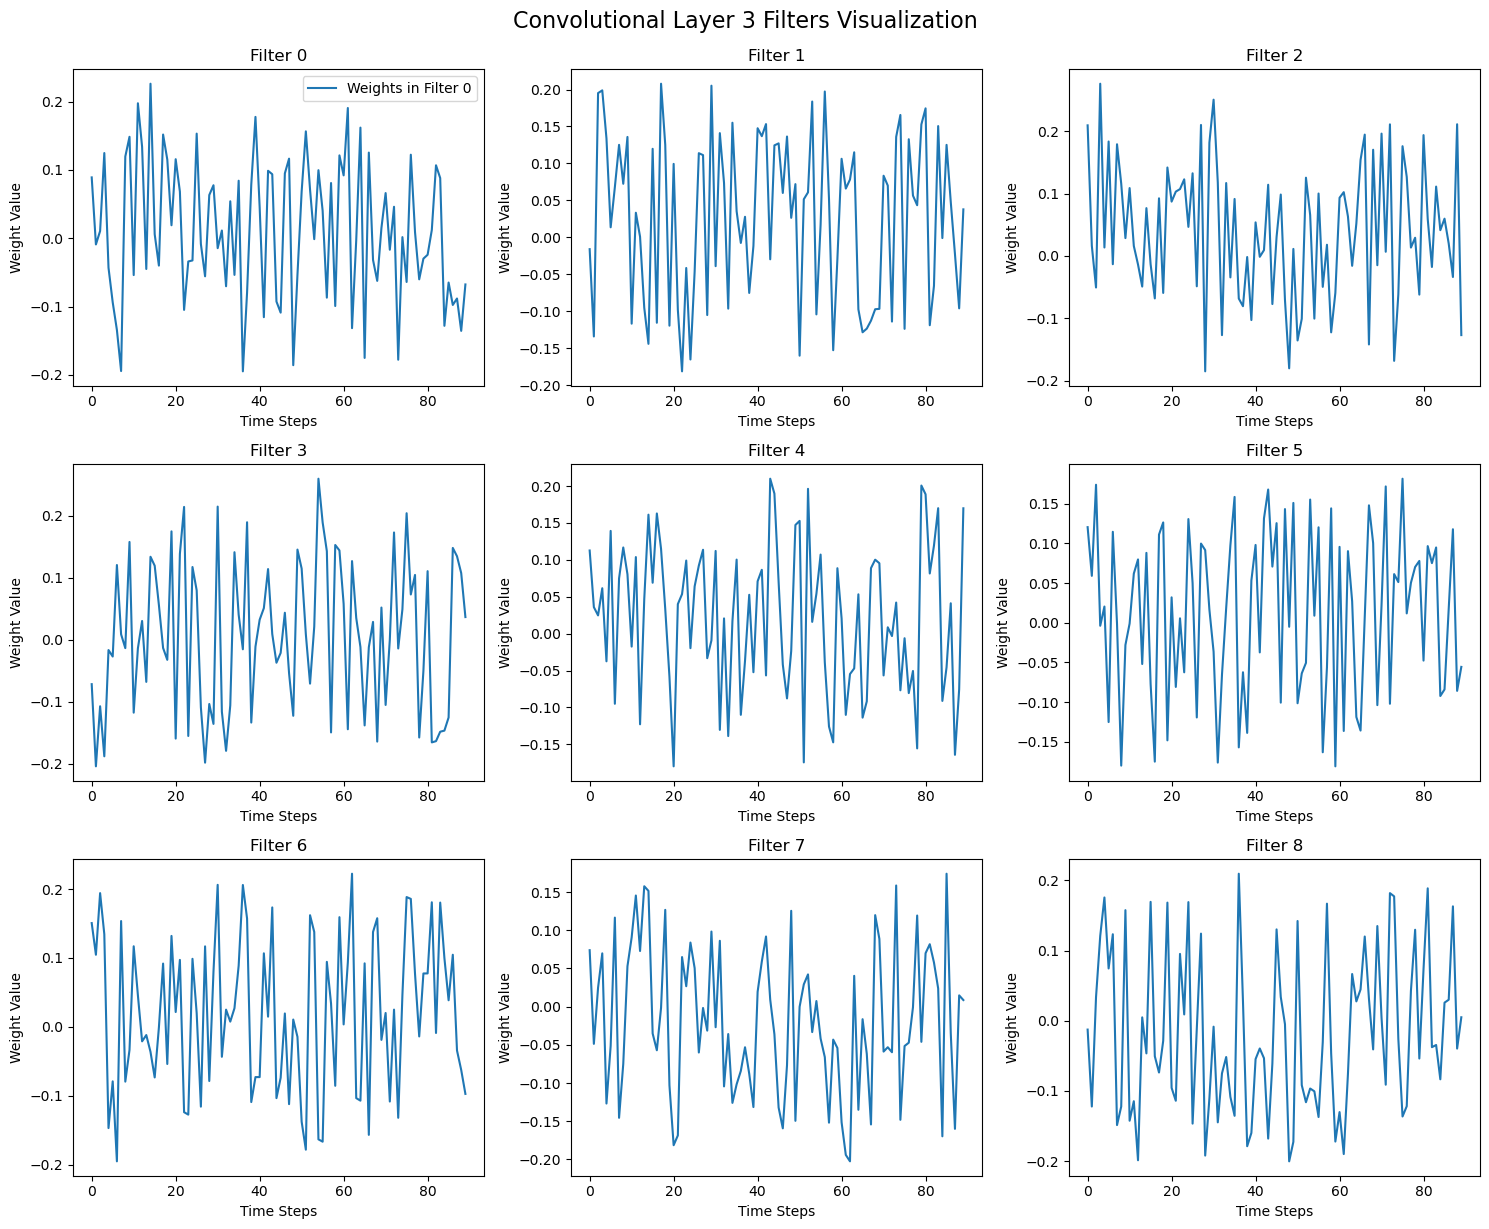

In [64]:
# Plot filters of the first convolutional layer
plot_conv1d_filters(model, layer_index=1)

# Plot filters of the second convolutional layer
plot_conv1d_filters(model, layer_index=3)

Epoch 1/1000
25000/25000 [==============================] - 103s 4ms/step - loss: 2.2247e-05 - val_loss: 0.0000e+00
Epoch 2/1000
25000/25000 [==============================] - 98s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/1000
25000/25000 [==============================] - 99s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/1000
25000/25000 [==============================] - 99s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/1000
25000/25000 [==============================] - 97s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/1000
25000/25000 [==============================] - 98s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/1000
25000/25000 [==============================] - 96s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/1000
25000/25000 [==============================] - 98s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/1000
25000/25000 [==============================] - 98s 4ms/step - loss

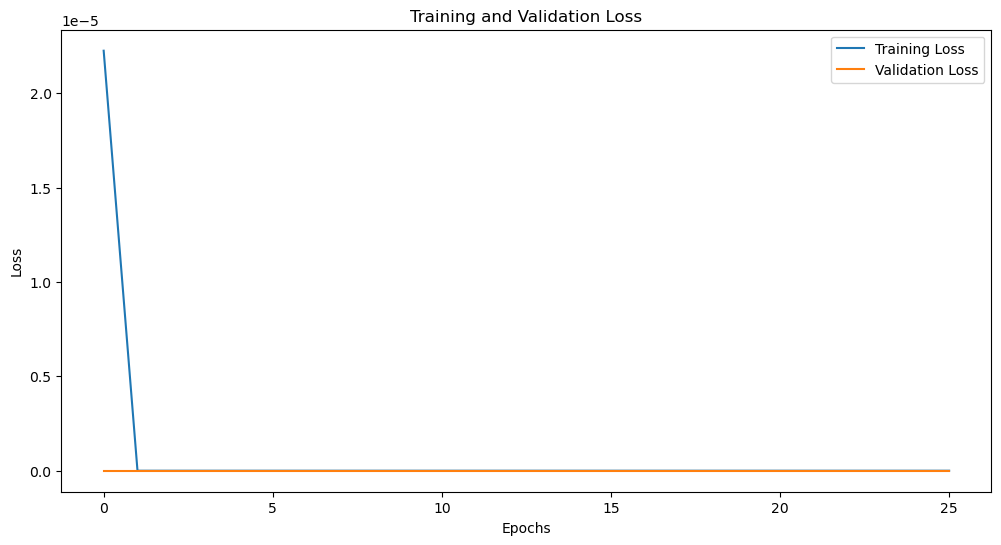

31250/31250 [==============================] - 145s 5ms/step - loss: 1.1901e-04


In [65]:
# Set the early stopping patience and learning rate as variables
patience = 25
learning_rate = 1e-3

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

# Compile the model with the specified learning rate
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

# Train the model with the callback
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Determine the optimal number of epochs from early stopping
optimal_epochs = early_stopping.stopped_epoch - patience + 1  # Adjust for the offset

# Retrain the model on the full dataset
full_X = np.concatenate((X_train, X_test))
full_y = np.concatenate((y_train, y_test))

final_model = create_cnn_model()  # Recreate the model architecture
final_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')  # Compile the model just like before

# Train on the full dataset
final_model.fit(full_X, full_y, epochs=optimal_epochs, batch_size=32, verbose=1)

### After training

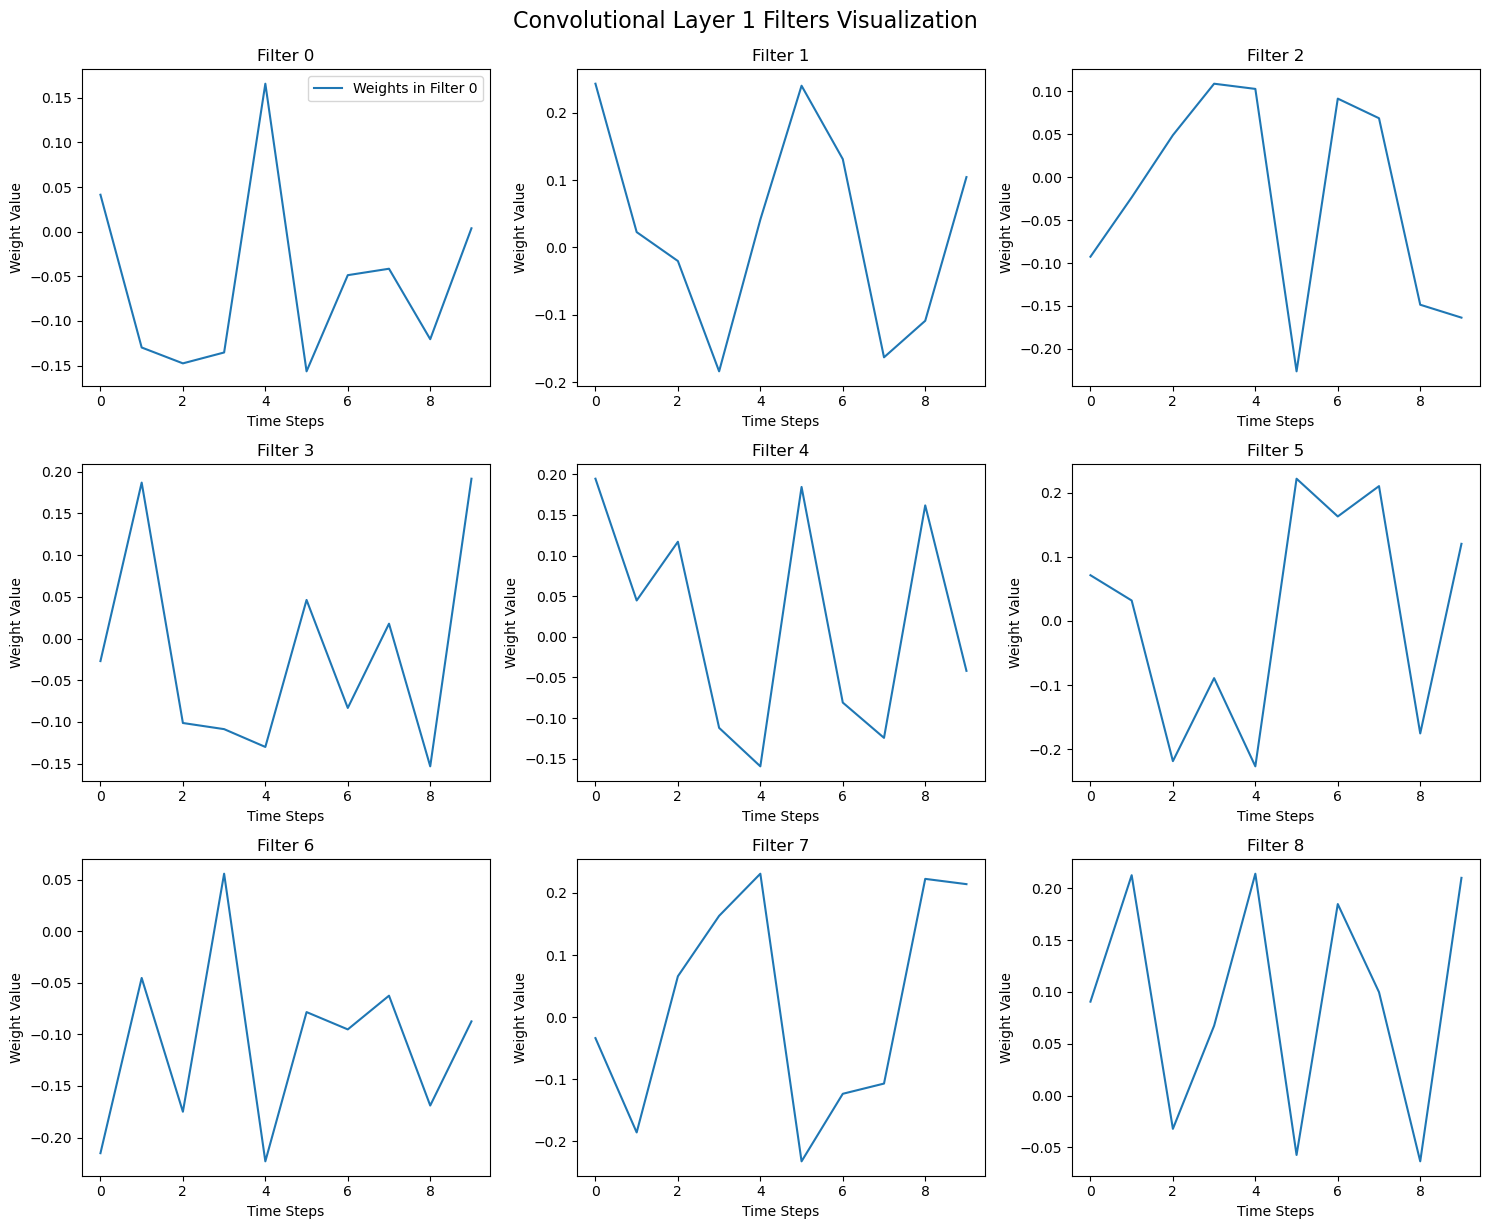

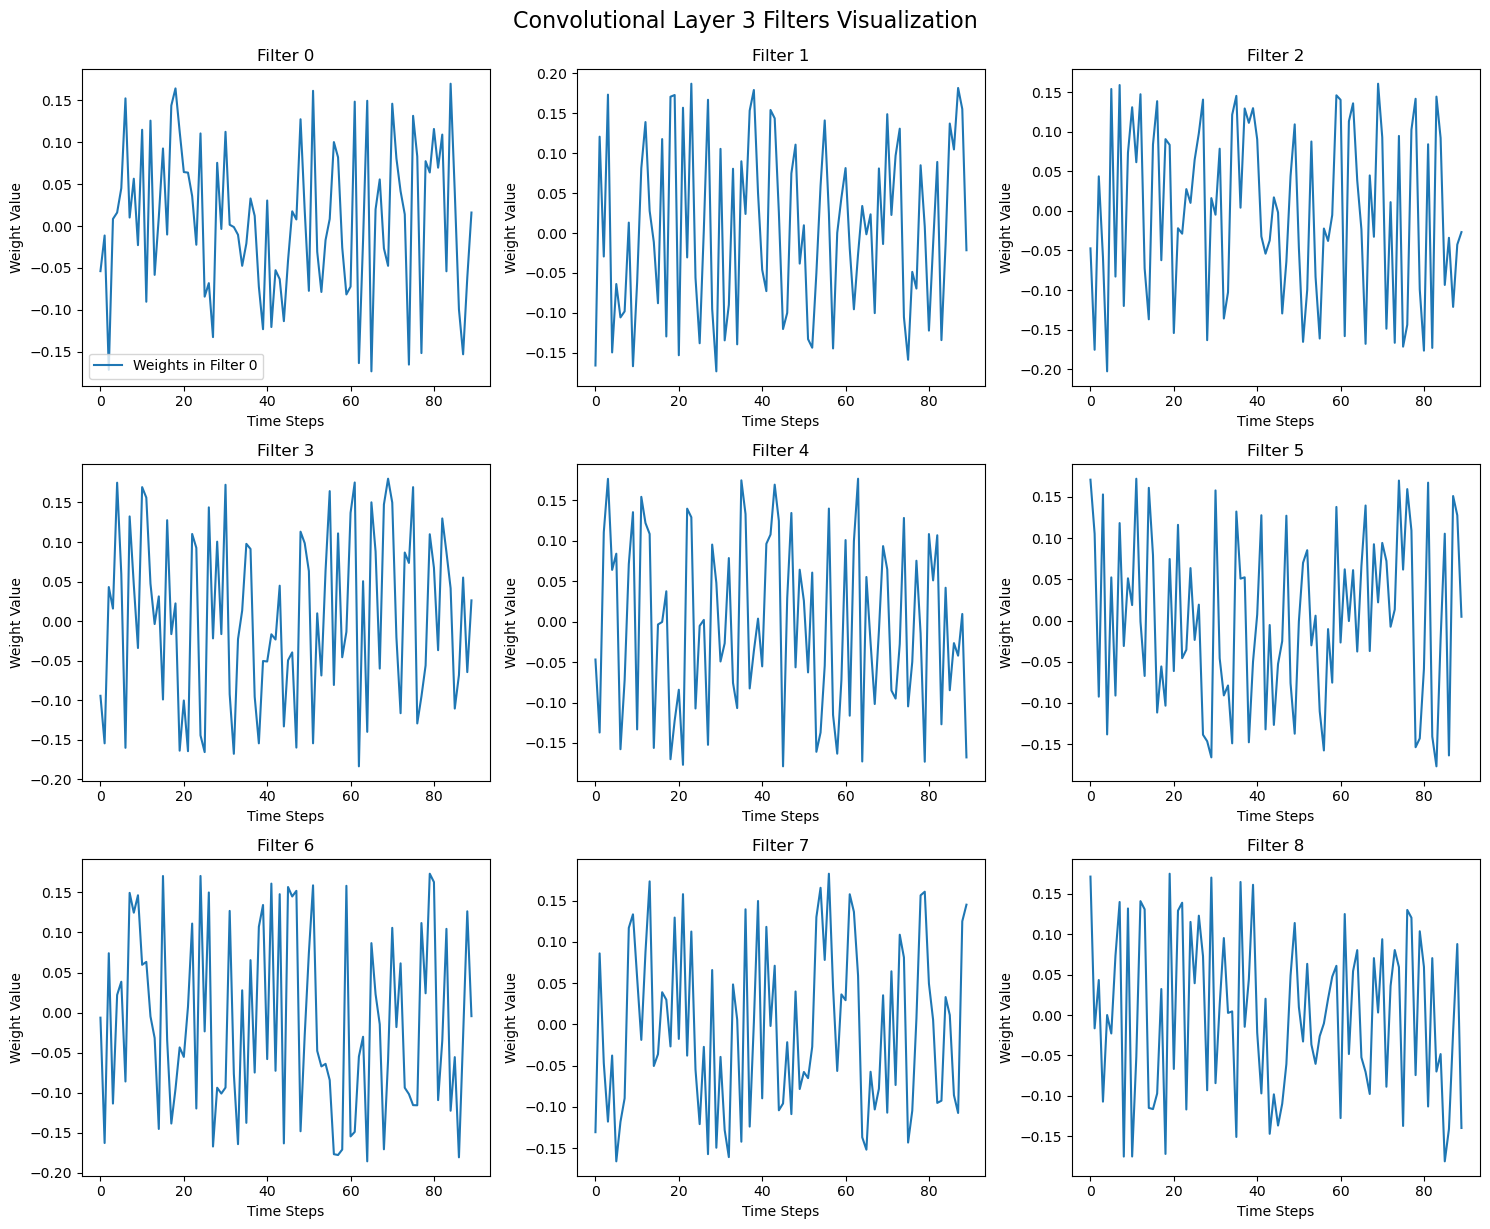

In [66]:
# Plot filters of the first convolutional layer
plot_conv1d_filters(final_model, layer_index=1)

# Plot filters of the second convolutional layer
plot_conv1d_filters(final_model, layer_index=3)